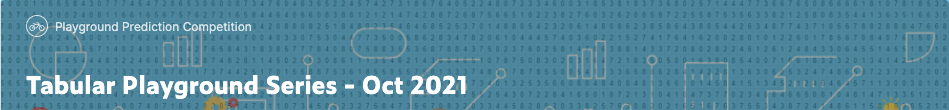

### Copy Files Locally

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/TPS\ 2021-10/{train,test}.feather /content/drive/MyDrive/Colab\ Notebooks/TPS\ 2021-10/sample_submission.csv /content/

### Install Packages

In [3]:
# # plotly is old in Colab
# !pip install plotly -U

### Initialization

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import os
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from collections import Counter
import math
import platform
import seaborn as sns

sns.set_style("ticks")
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    Normalizer,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
)
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
import functools
import warnings
import gc

warnings.filterwarnings("ignore")

running_on = platform.system()

if running_on == "Windows":
    drive_path = r"C:\Users\pmm\My Drive\Colab Notebooks\TPS 2021-11"
elif running_on == "Darwin":
    drive_path = "/Users/pmm/My Drive/Colab Notebooks/TPS 2021-11"
elif "google.colab" in str(get_ipython()):
    drive_path = "/content"

path = drive_path
now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")

In [5]:
# from torch import cuda

# try:
#     my_gpu = {cuda.get_device_name(0)}
# except:
#     my_gpu = "not found (sad trombone)"

# print(f"GPU is {my_gpu}")

In [4]:
# train_data = pd.read_csv(os.path.join(path, "train.csv")).to_feather(os.path.join(path, "train.feather"))
# train_data = pd.read_csv(os.path.join(path, "test.csv")).to_feather(os.path.join(path, "test.feather"))


train_data = pd.read_feather(os.path.join(path, "train.feather")).drop(
    columns=["id"]
)
test_data = pd.read_feather(os.path.join(path, "test.feather")).drop(
    columns=["id"]
)

### EDA

#### &nbsp;&nbsp;&nbsp;&nbsp;train data evaluation

In [7]:
# quick look at the train data
train_data.head(5).style.set_properties(
    **{
        "background-color": "white",
        "color": "darkblue",
        "border-color": "dark",
    }
)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0.106643,3.594370,132.804000,3.184280,0.081971,1.188590,3.732380,2.266270,2.099590,0.012330,1.607190,-0.318058,0.560137,2.806880,1.351140,2.535930,0.197527,0.676494,1.989790,-3.842450,0.037380,0.230322,3.330550,0.009397,0.144738,3.051310,1.303620,0.033225,-0.018284,2.748210,-0.009294,-0.036271,-0.049871,0.019484,3.898460,11.286300,1.138020,3.366880,4.944460,-0.105772,2.113450,3.452230,0.789430,1.113210,1.491570,2.440370,0.041824,3.355370,0.053691,1.701270,0.908831,0.094902,0.030219,0.597024,4.443410,1.586490,-0.068686,-0.108268,0.061044,0.046099,0.017113,-0.027551,0.019483,-0.048826,0.050748,3.729300,5.017440,4.186880,0.063342,0.121043,1.371750,4.017450,0.167613,0.039753,2.042360,-0.016614,0.107679,3.507250,0.013660,-0.097023,5.396070,0.244457,3.491840,0.113090,-0.015472,4.208790,4.106560,0.037227,-0.118814,0.067086,0.010739,1.098620,0.013331,-0.011715,0.052759,0.065400,4.211250,1.978770,0.085974,0.240496,0
1,0.125021,1.673360,76.533600,3.378250,0.099400,5.093660,1.275620,-0.471318,4.545940,0.037706,0.331749,0.325091,0.062040,2.262150,4.339430,-0.224999,0.233586,3.381280,1.902990,0.067874,-0.051268,0.006135,2.604440,0.103441,0.067638,4.753620,1.855520,-0.181834,0.008359,3.166340,0.011850,0.022292,0.069320,0.117109,0.315276,24.480700,1.672270,-0.409067,4.954750,0.092358,2.603180,1.954690,0.005896,3.289340,2.564530,0.817706,0.025997,4.617490,1.575540,0.066105,0.681634,0.025247,0.183500,0.110038,2.746120,0.835586,0.188196,4.960640,0.136087,-0.008493,-0.015264,-0.010841,0.064584,0.102548,0.093611,0.964089,0.630422,4.307340,0.091289,-0.036360,3.617670,3.103240,0.000657,0.051302,1.924620,0.123294,-0.022671,1.548120,-0.010397,0.058330,3.661310,-0.118386,2.357390,-0.009112,0.178701,4.097350,3.532890,0.005244,0.121381,0.109968,0.135838,3.460170,0.017054,0.124863,0.154064,0.606848,-0.267928,2.577860,-0.020877,0.024719,0
2,0.036330,1.497470,233.546000,2.194350,0.026914,3.126940,5.056870,3.849460,1.801870,0.056995,0.328684,2.968810,0.105244,2.069490,5.309860,1.354790,-0.262018,1.379080,1.480910,0.020542,-0.008806,0.109348,1.683650,0.038180,0.123716,1.112480,3.571660,0.120601,0.082069,2.233520,0.002270,0.045182,0.014405,0.011599,-0.502849,33.738200,1.417500,1.071350,3.222960,2.122030,3.082160,0.637555,-0.006822,-0.390943,17.345700,3.700430,-0.033600,1.578240,0.051978,-0.002004,2.690960,0.018367,-0.030468,0.111409,2.187470,-0.325000,-0.019944,3.455030,0.068105,-0.009812,-0.010627,0.027571,-0.007121,-0.048914,-0.002574,1.865090,2.404170,0.411741,0.057749,0.525174,2.168790,0.828297,0.089848,0.093744,4.949010,-0.010978,0.076671,0.266784,0.038691,0.382731,3.847600,-0.121482,3.740840,0.147098,-0.016566,0.614651,2.125840,0.078828,0.979808,0.026758,0.117310,4.883000,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.141120,0.124464,0.148209,0
3,-0.014077,0.246000,779.967000,1.890640,0.006948,1.531120,2.698000,4.517330,4.503320,0.123494,1.002680,4.869600,0.058411,2.497850,1.238430,2.348360,0.175475,1.608890,2.028810,0.042086,0.005141,0.076506,1.651220,0.111813,0.121641,0.589120,4.236920,-0.032843,0.058168,0.712927,0.097465,0.072744,0.000324,0.063362,4.063820,25.382400,0.576572,2.026210,2.968430,1.085670,1.710880,1.371820,0.034631,0.722607,71.448500,3.034580,0.092245,3.453100,0.044829,0.027195,4.082850,0.046955,0.063695,0.029225,0.672022,0.185311,0.164284,3.804560,0.062306,-0.021406,0.009471,0.110884,0.026837,2.931160,0.068112,-0.495192,1.345280,2.242750,0.035611,-0.139274,4.742430,3.292740,0.117877,0.065605,0.556711,-0.058029,0.070501,1.101250,0.068559,0.162928,4.070180,-0.008835,3.896780,0.913739,-0.163204,3.074850,4.356780,-0.048894,4.917990,0.069930,-0.01

In [8]:
print(
    f"Number of rows: {train_data.shape[0]};  Number of columns: {train_data.shape[1]}; No of missing values: {sum(train_data.isna().sum())}"
)

Number of rows: 600000;  Number of columns: 101; No of missing values: 0


In [9]:
num_nans = (
    train_data.loc[:, (train_data.isnull().sum() > 0)]
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

if len(num_nans) > 0:
    print("Number of misssing values by feature (nonzero)")
    num_nams.to_frame(name="NaNs").style.set_properties(
        **{
            "background-color": "white",
            "color": "darkred",
            "border-color": "dark",
        }
    )
else:
    print("No missing values in train data")

No missing values in train data


In [10]:
import pprint

print("Info about the train data:")
dict(Counter(train_data.dtypes.values))

Info about the train data:


{dtype('float64'): 100, dtype('int64'): 1}

In [28]:
frac = 1
train_data.sample(frac=frac, axis=1).describe().T.style.bar(
    subset=["mean"], color="lightblue"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
f66,600000.000000,2.577005,1.563820,-1.260920,1.314975,2.529290,3.867983,6.307160
f87,600000.000000,0.265197,0.562230,-2.544860,0.018962,0.081708,0.180659,8.730670
f19,600000.000000,0.108097,0.395313,-5.334110,0.017039,0.059506,0.102623,11.687500
f49,600000.000000,0.244993,0.622615,-2.247330,0.016608,0.068306,0.132289,7.234150
f43,600000.000000,2.500058,1.575150,-1.246410,1.173660,2.497610,3.769982,6.507140
f56,600000.000000,0.270019,0.852348,-3.247350,-0.004716,0.056817,0.129584,10.710600
f92,600000.000000,0.155260,0.548397,-9.761770,0.018904,0.068906,0.125165,18.412800
f37,600000.000000,2.595079,1.562506,-1.210370,1.306240,2.599130,3.884860,6.255900
f27,600000.000000,0.057945,0.114129,-2.281050,-0.018820,0.058764,0.134818,3.752360
f62,600000.000000,0.124303,0.414040,-2.553080,0.011139,0.053375,0.098802,8.583710


In [12]:
# variables variation
train_data.var()
# Standard  deviation
train_data.std()

f0             0.272954
f1             2.414971
f2        304421.323062
f3             2.385571
f4             0.174297
              ...      
f96            2.428695
f97            2.325903
f98            0.190262
f99            0.070170
target         0.249964
Length: 101, dtype: float64

f0          0.522450
f1          1.554018
f2        551.743893
f3          1.544529
f4          0.417488
             ...    
f96         1.558427
f97         1.525091
f98         0.436190
f99         0.264896
target      0.499964
Length: 101, dtype: float64

In [13]:
# Correlation matrix
corr_matrix = train_data.corr(method="pearson", min_periods=1)
corr_matrix

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
f0,1.000000,0.005288,-0.002627,-0.003714,0.013101,-0.002081,-0.004594,-0.003715,-0.007836,0.005646,...,-0.002431,-0.003203,0.000666,-0.005514,-0.001556,-0.014159,-0.016717,0.000539,0.008145,0.001653
f1,0.005288,1.000000,0.009679,-0.014078,-0.001013,0.008854,0.004880,-0.002326,0.020885,0.008804,...,-0.002975,-0.007733,0.006767,-0.009169,0.003269,0.012188,0.002068,0.002157,0.002548,-0.025762
f2,-0.002627,0.009679,1.000000,-0.002295,-0.015797,0.011925,-0.000030,-0.004807,0.006432,0.008650,...,0.001939,0.000458,0.005432,0.002372,0.002854,0.002000,-0.001779,-0.001412,-0.001729,-0.023432
f3,-0.003714,-0.014078,-0.002295,1.000000,-0.010610,-0.021345,0.000324,0.000108,-0.003198,0.000145,...,0.011295,-0.004317,-0.000742,0.005074,0.020866,-0.007060,0.009756,-0.010952,0.000703,-0.041314
f4,0.013101,-0.001013,-0.015797,-0.010610,1.000000,0.000774,-0.004948,-0.001994,0.000292,-0.000414,...,-0.003535,-0.000355,0.008593,-0.009358,-0.004059,-0.002618,-0.011757,0.012426,0.002732,0.031278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f96,-0.014159,0.012188,0.002000,-0.007060,-0.002618,0.012564,0.004777,0.019258,-0.003765,-0.007275,...,-0.017331,0.004584,-0.000846,-0.002894,-0.004823,1.000000,-0.007190,-0.001376,-0.008083,0.059307
f97,-0.016717,0.002068,-0.001779,0.009756,-0.011757,-0.006829,-0.015344,-0.002281,-0.001995,0.001856,...,0.006754,0.002675,-0.000117,0.008985,-0.003586,-0.007190,1.000000,-0.002561,0.002204,-0.080727
f98,0.000539,0.002157,-0.001412,-0.010952,0.012426,0.008329,-0.001864,-0.001392,0.006603,-0.002524,...,-0.005145,-0.008048,-0.005267,-0.002564,-0.003504,-0.001376,-0.002561,1.000000,-0.006297,0.047160
f99,0.008145,0.002548,-0.001729,0.000703,0.002732,0.007394,0.009251,0.006628,-0.008832,0.006993,...,0.002562,0.003759,-0.002089,0.003564,-0.009223,-0.008083,0.002204,-0.006297,1.000000,-0.011223


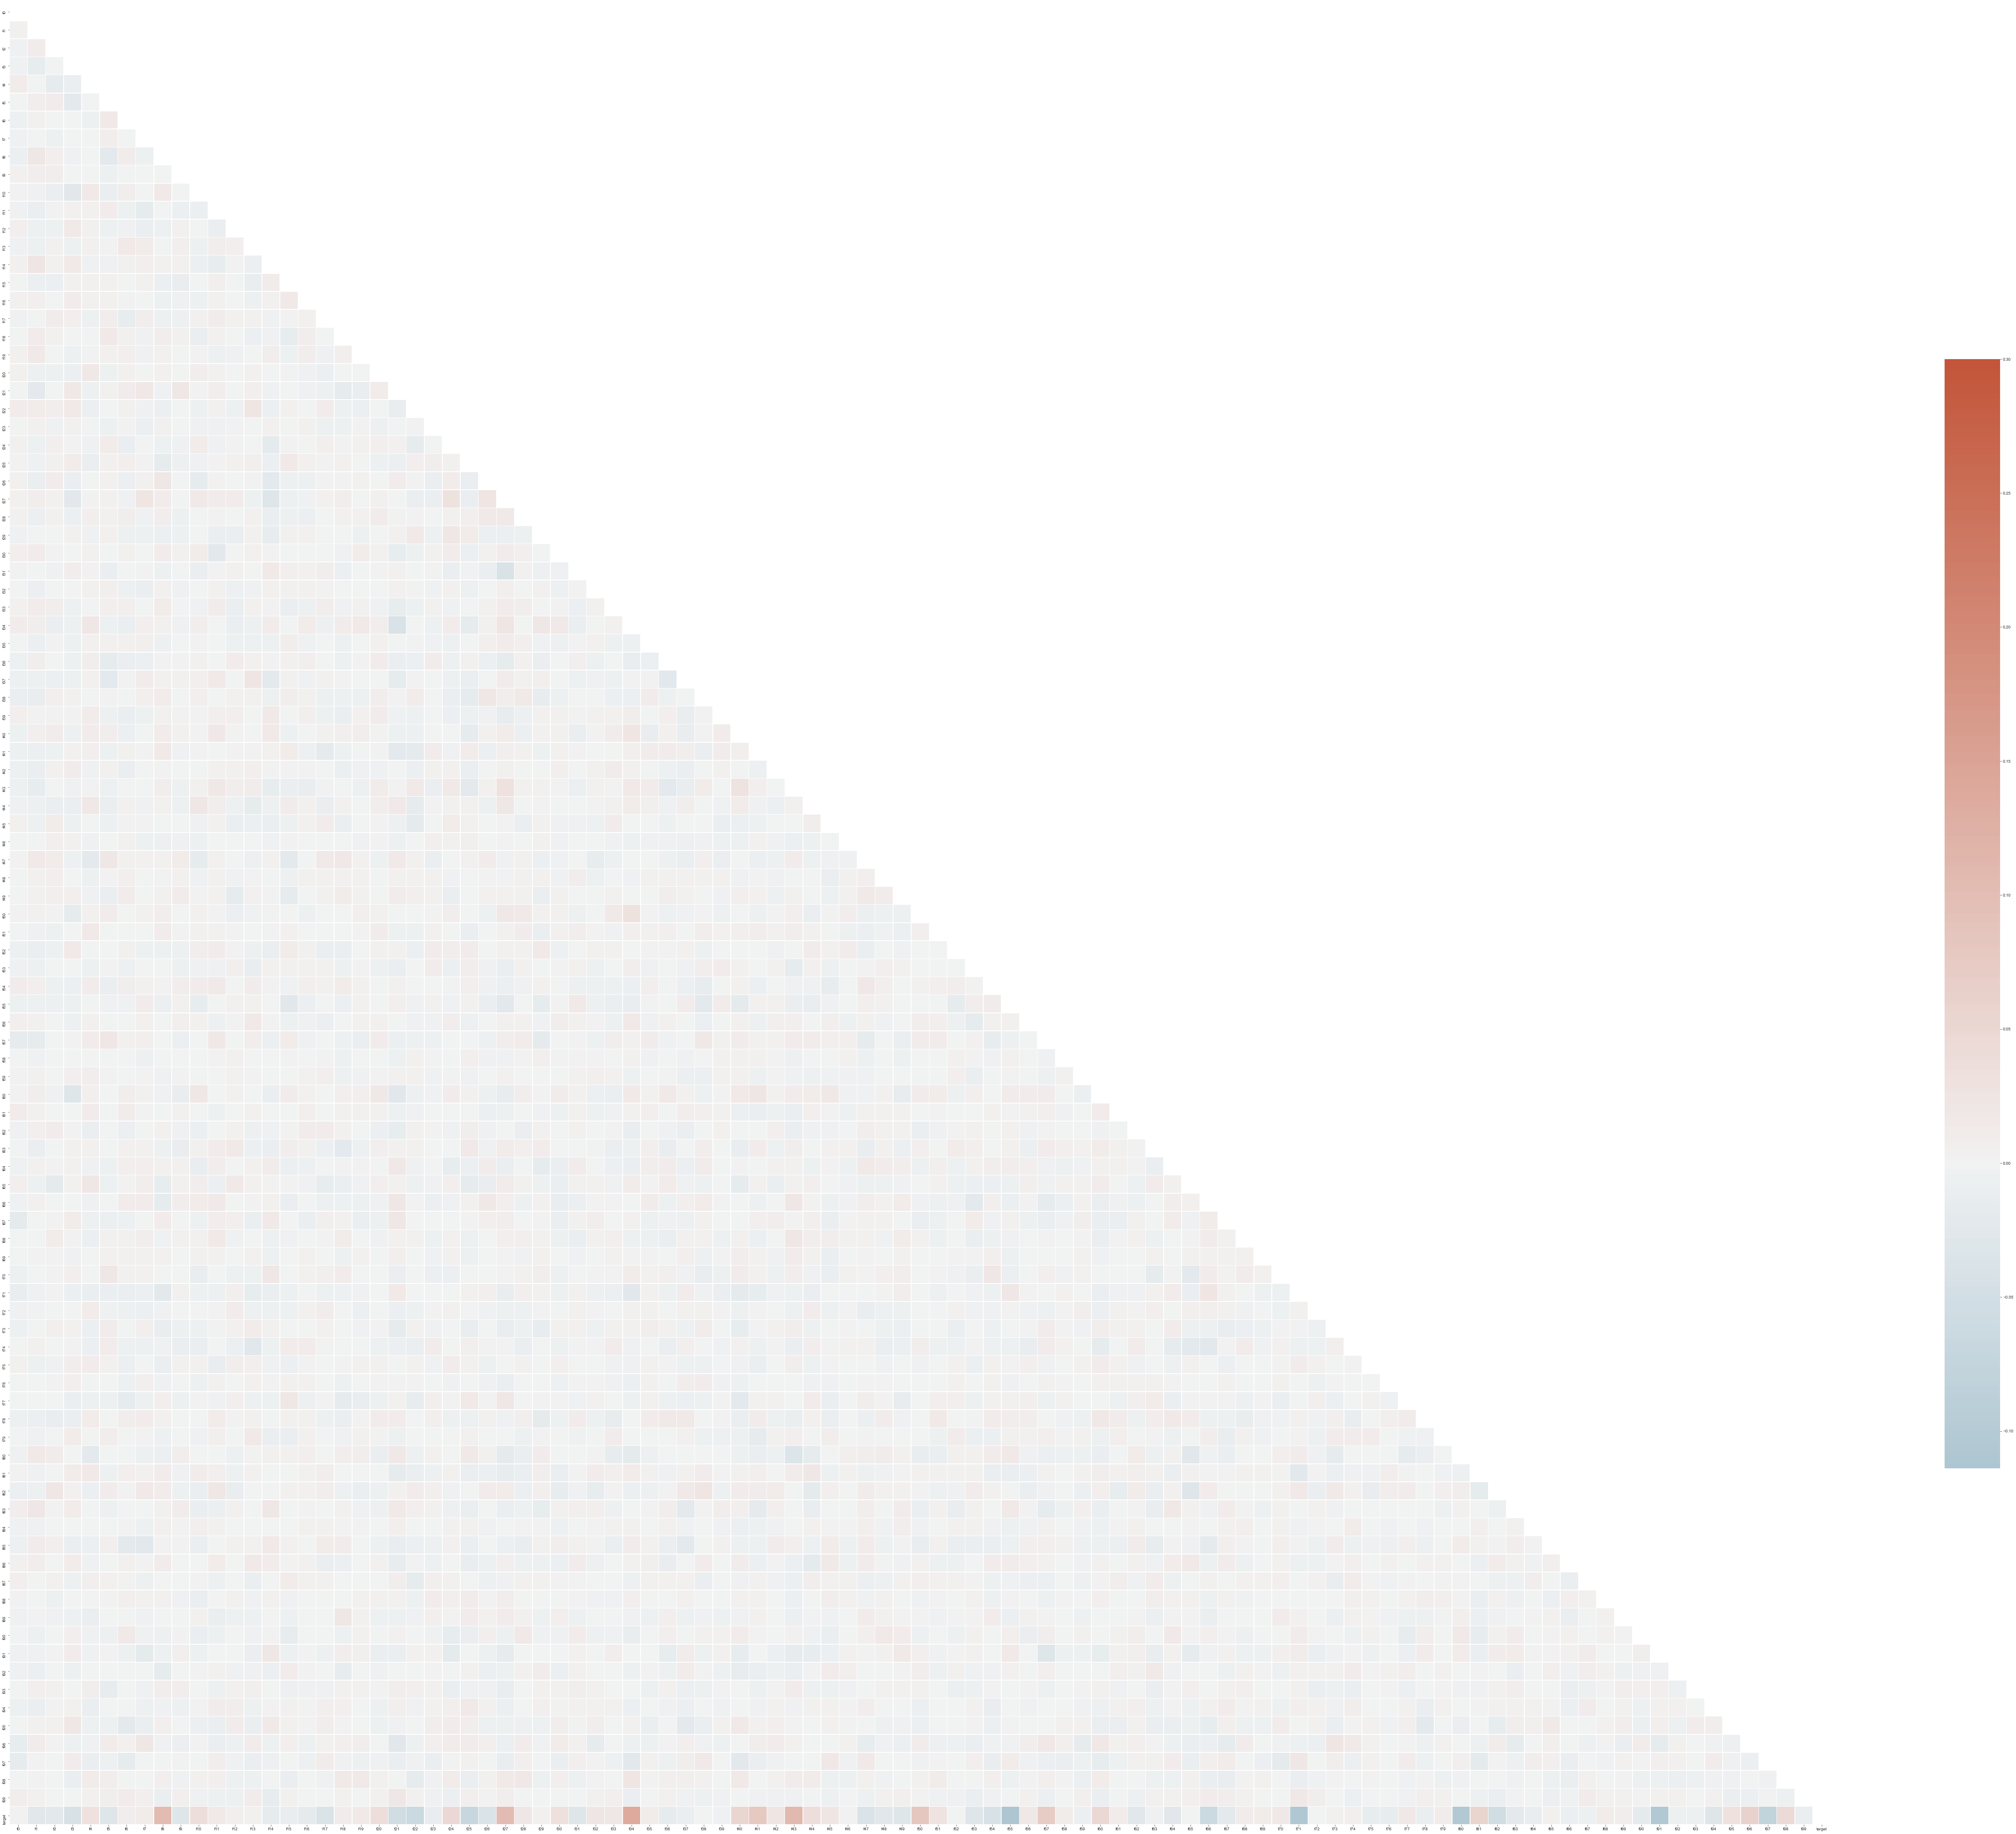

In [26]:
# Correlation heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(100, 100))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

_ = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

In [15]:
corr_targ = train_data.corrwith(train_data["target"])
corr_targ[abs((corr_targ) > 0.3)]

target    1.0
dtype: float64

In [16]:
print("percentage of target values:")
percent_value = pd.DataFrame(
    train_data["target"].value_counts() / len(train_data) * 100
)
percent_value.T.style.set_precision(2)

percentage of target values:


,1,0
target,50.60,49.40


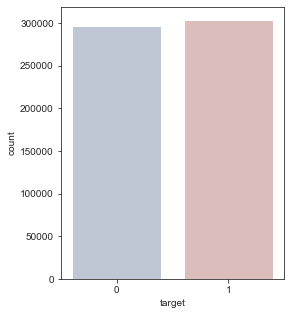

In [17]:
# visualization
fig, ax = plt.subplots(figsize=(4, 5))
ax = sns.countplot(train_data["target"], palette="vlag")

In [18]:
test_data.head(5).style.set_properties(
    **{
        "background-color": "white",
        "color": "darkblue",
        "border-color": "dark",
    }
)  # head

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.003229,4.838660,585.529000,2.282910,0.713180,3.907830,0.480696,1.482270,4.891810,0.056351,4.200990,3.151800,0.000349,1.851160,2.638890,0.746668,-0.004756,1.610300,4.114820,-0.077756,0.129446,0.053324,0.416789,0.445009,0.150464,5.021300,2.221390,-0.072333,-0.215874,1.562360,0.074881,0.010050,0.018582,0.067466,5.578300,3.085560,3.842470,0.011125,2.359970,0.695092,-0.345747,4.388170,0.054919,2.803600,3.872340,3.974520,0.157887,0.704785,-0.001126,-0.004548,1.010820,0.094506,0.016935,0.100871,4.366950,1.832040,0.019682,1.964200,0.120581,0.080247,0.027516,0.048825,0.074626,0.041264,0.069319,4.248810,2.091950,0.695042,0.007464,-0.017882,1.883500,1.268030,0.023747,0.043071,3.174780,0.074356,0.125909,3.926430,0.046914,-0.042290,3.019250,0.089564,3.200700,0.009679,-0.099653,3.573060,4.797270,0.091985,0.773543,0.073380,0.112910,1.073550,0.122149,0.086330,0.036010,0.010619,0.290343,1.898200,0.131533,0.012047
1,0.008602,0.505536,-100.099000,3.012670,0.027199,1.194610,5.036620,2.517440,4.553890,0.063876,0.337257,4.439690,0.013188,3.379010,3.384700,1.167400,2.246550,1.750170,2.766240,-0.058501,0.012595,0.036144,0.769057,0.017496,0.050283,0.324697,4.948640,0.124789,0.347128,1.245120,0.035822,-0.013188,0.023194,0.006444,4.983330,23.706900,8.287290,4.796230,1.799280,-0.050040,1.973320,1.912010,0.035974,2.572370,6.321260,0.442628,0.148115,1.311350,0.106667,0.626128,2.309730,-0.044350,0.194283,0.131445,4.266670,0.715653,0.017117,2.839080,0.104712,-0.007952,0.067650,0.066438,0.034258,0.606144,0.019988,-0.456704,3.378770,1.900050,0.052316,-0.050397,2.612950,3.112540,0.022305,0.108325,4.617640,0.091440,0.039368,3.035190,1.023050,-0.020578,2.771560,3.309480,5.058400,-0.003993,0.067636,0.995391,2.471650,-0.015214,0.263423,-0.021910,-0.020214,2.622340,0.123307,0.033063,0.123059,0.005771,-0.392923,3.689640,0.047418,0.120015
2,1.461000,2.437260,-112.964000,3.541230,0.752338,4.338310,1.648080,4.699910,1.950250,0.005303,2.071680,0.546499,0.141781,1.673170,4.306490,1.702330,-0.062869,1.619230,4.190530,0.055140,-0.016590,0.017805,3.064810,0.070370,0.098316,3.507540,1.069100,0.012750,0.009981,3.467810,0.035920,-0.009804,0.065728,-0.004725,5.281020,11.528800,0.171694,4.394570,2.520840,0.079365,5.451320,1.785820,0.029620,3.063830,5.275990,0.315972,0.148310,0.463193,-0.039962,0.150592,3.754600,0.024164,0.107455,0.048741,3.582400,0.966391,-0.058947,1.869830,0.029872,-0.044294,0.065172,-0.003328,-0.001950,0.095007,0.080267,3.337300,3.604890,4.694580,0.075650,-0.088276,1.772440,-0.142226,0.000918,0.021483,0.241844,0.067591,-0.026572,0.894909,0.111606,0.524423,1.450070,0.019355,1.271350,0.076042,0.446993,4.406990,2.446970,-0.041154,0.212414,0.141005,-0.011036,2.030180,-0.000426,0.084091,0.123605,0.499554,4.054650,3.330670,0.108843,0.064687
3,0.140556,3.085610,179.451000,0.573945,0.057342,2.216790,1.623480,0.526174,1.542540,-0.026160,1.609440,1.723560,-0.019564,1.552130,4.832640,1.501640,0.192669,4.614890,1.470690,-0.010031,0.072805,0.048035,3.230210,-0.031548,0.028697,3.752520,4.948470,-0.174542,-0.033491,2.478230,0.068129,0.090797,0.029877,0.146718,3.169830,-12.984600,3.135210,1.765010,3.253990,0.713238,3.729920,2.651530,0.080945,1.056490,1.452600,1.814190,0.077875,2.721310,0.004530,0.108844,2.834450,0.024642,-0.051423,0.060574,3.420200,1.283600,-0.083213,0.048820,-0.002502,0.051387,0.075775,-0.008900,0.141776,0.173123,0.012894,3.390590,2.698990,0.059916,0.055400,-0.000140,2.641440,0.839721,-0.026268,0.058745,2.521910,0.118737,0.134899,2.839480,0.108751,-0.015848,1.147240,0.390064,3.309230,-0.046117,-0.206052,2.373770,3.159410,0.131234,1.031180,0.026155,0.050117,0.221613,0.0452

In [19]:
print(
    f"Number of rows: {test_data.shape[0]};  Number of columns: {test_data.shape[1]}; No of missing values: {sum(test_data.isna().sum())}"
)

Number of rows: 540000;  Number of columns: 100; No of missing values: 0


In [20]:
num_nans = (
    test_data.loc[:, (test_data.isnull().sum() > 0)]
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

if len(num_nans) > 0:
    print("Number of misssing values by feature (nonzero)")
    num_nams.to_frame(name="NaNs").style.set_properties(
        **{
            "background-color": "white",
            "color": "darkred",
            "border-color": "dark",
        }
    )
else:
    print("No missing values in test data")

No missing values in test data


In [21]:
print("Info about test data: ")
test_data.info()

Info about test data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 100 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      540000 non-null  float64
 1   f1      540000 non-null  float64
 2   f2      540000 non-null  float64
 3   f3      540000 non-null  float64
 4   f4      540000 non-null  float64
 5   f5      540000 non-null  float64
 6   f6      540000 non-null  float64
 7   f7      540000 non-null  float64
 8   f8      540000 non-null  float64
 9   f9      540000 non-null  float64
 10  f10     540000 non-null  float64
 11  f11     540000 non-null  float64
 12  f12     540000 non-null  float64
 13  f13     540000 non-null  float64
 14  f14     540000 non-null  float64
 15  f15     540000 non-null  float64
 16  f16     540000 non-null  float64
 17  f17     540000 non-null  float64
 18  f18     540000 non-null  float64
 19  f19     540000 non-null  float64
 20  f20     540000 non-null 

In [30]:
frac = 1
test_data.sample(frac=frac, axis=1).describe().T.style.bar(
    subset=["mean"], color="lightblue"
).background_gradient(subset=["std"], cmap="Blues").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
f9,540000.000000,0.125970,0.399739,-2.692380,0.019464,0.057811,0.098911,7.819170
f56,540000.000000,0.213250,0.748498,-3.130120,-0.004976,0.056227,0.122764,10.734000
f87,540000.000000,0.303057,0.595756,-2.552360,0.023966,0.092461,0.309661,8.975590
f52,540000.000000,0.224570,0.501508,-2.476220,0.000500,0.073726,0.172078,7.452870
f26,540000.000000,2.400214,1.562755,-1.172900,1.094765,2.288830,3.727575,6.191830
f97,540000.000000,2.640276,1.537125,-1.232050,1.385690,2.740695,3.903460,6.421930
f73,540000.000000,0.047352,0.049721,-0.753267,0.022236,0.045585,0.069524,1.812140
f81,540000.000000,0.964903,1.398737,-4.156410,0.067456,0.346572,1.442160,16.121000
f22,540000.000000,2.641143,1.583642,-1.398120,1.340670,2.679495,3.946415,6.333920
f67,540000.000000,2.504257,1.537031,-1.397900,1.262230,2.462940,3.727372,6.520710


#### &nbsp;&nbsp;&nbsp;&nbsp; Feature distributions: train vs. test

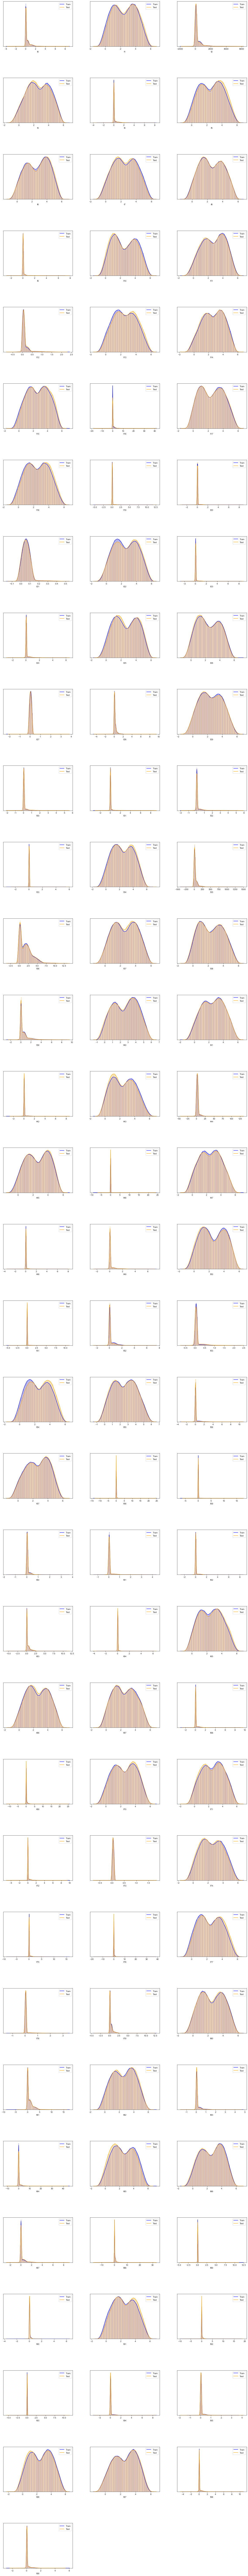

In [27]:
cols = train_data.drop(["target"], axis=1).columns
length = len(cols)
_ = plt.subplots(figsize=(20, 320))
for i, col in enumerate(cols):
    fig = plt.subplot((length / 2), 3, i + 1)
    plt.subplots_adjust(wspace=0.25, hspace=0.7)
    _ = plt.yticks([])
    _ = sns.distplot(
        train_data[col], color="blue", kde=True, bins=120, label="train"
    )
    _ = sns.distplot(
        test_data[col], color="orange", kde=True, bins=120, label="test"
    )
    _ = fig.legend(labels=("Train", "Test"))

In [ ]:
raise  # hell